In [1]:
# imports
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

# Data Exploration

In [2]:
# load in dataset
df = pd.read_csv('MLB-Stats.csv')
print(df.shape)
df.head()

(28293, 28)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,RBI,SB,BB,SO,salary,IBB,HBP,SH,SF,PA
0,aardsda01,David Aardsma,215,75,R,R,2004,NL,SFN,San Francisco Giants,...,0,0,0,0,300000,0,0,0,0,0
1,aardsda01,David Aardsma,215,75,R,R,2007,AL,CHA,Chicago White Sox,...,0,0,0,0,387500,0,0,0,0,0
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0,0,0,1,403250,0,0,0,0,1
3,aardsda01,David Aardsma,215,75,R,R,2009,AL,SEA,Seattle Mariners,...,0,0,0,0,419000,0,0,0,0,0
4,aardsda01,David Aardsma,215,75,R,R,2012,AL,NYA,New York Yankees,...,0,0,0,0,500000,0,0,0,0,0


In [3]:
# df = df[df['Season'] == 2016]
# df.head()

In [4]:
# check for any missing data
df.isnull().sum()

playerID       0
Player Name    0
weight         0
height         0
bats           0
throws         0
Season         0
League         0
teamID         0
Team           0
Franchise      0
G              0
AB             0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
BB             0
SO             0
salary         0
IBB            0
HBP            0
SH             0
SF             0
PA             0
dtype: int64

In [5]:
# interesting stat ideas
# avg salary by year - shows growth in cap, inflation
# total salary per team by year
# how has this changed since moneyball, statistics used to determine best value players?

In [6]:
# change column names from abbreviations to full names to help with domain knowledge
df = df.rename(columns={'G': 'Games_Played', 'AB': 'At_bats', 'R': 'Runs', 'H': 'Hits',
                   '2B': 'Doubles', '3B': 'Triples', 'HR': 'Home_Runs', 'SB': 'Stolen_Base',
                   'BB': 'Walk', 'SO': 'Strikeouts', 'IBB': 'Intentional_Walk', 'HBP': 'Hit_By_Pitch',
                   'SH': 'Sacrifice_Bunt', 'SF': 'Sacrifice_Fly', 'PA': 'Plate_Appearance'})
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance'],
      dtype='object')

In [7]:
# data exploration
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,28293.0,1.990493e+02,2.265398e+01,140.0,185.0,195.0,215.0,315.0
height,28293.0,7.350019e+01,2.286595e+00,66.0,72.0,74.0,75.0,83.0
Season,28293.0,2.000938e+03,8.900551e+00,1985.0,1994.0,2001.0,2009.0,2016.0
Games_Played,28293.0,6.393387e+01,4.728526e+01,1.0,26.0,50.0,101.0,163.0
At_bats,28293.0,1.618799e+02,1.994066e+02,0.0,1.0,57.0,298.0,716.0
Runs,28293.0,2.178684e+01,3.013390e+01,0.0,0.0,4.0,37.0,152.0
Hits,28293.0,4.262454e+01,5.620091e+01,0.0,0.0,10.0,76.0,262.0
Doubles,28293.0,8.220655e+00,1.140145e+01,0.0,0.0,2.0,14.0,59.0
Triples,28293.0,9.091648e-01,1.832408e+00,0.0,0.0,0.0,1.0,23.0
Home_Runs,28293.0,4.776977e+00,8.384449e+00,0.0,0.0,0.0,6.0,73.0


# Feature Engineering

In [8]:
# batting average - hits divided by total at-bats
df['Batting_Average'] = df['Hits'] / df['At_bats']

In [9]:
# how frequently a batter reaches base per plate appearance
# times on base include hits, walks and hit-by-pitches
df['On_Base_Percentage'] = (df['Hits'] + df['Walk'] + df['Hit_By_Pitch']) / df['Plate_Appearance']

In [10]:
# slugging percentage = (1B + 2Bx2 + 3Bx3 + HRx4)/AB
df['Slugging_Percentage'] = ((df['Hits'] - df['Doubles'] - df['Triples'] - df['Home_Runs']) +
                             (df['Doubles'] * 2) + (df['Triples'] * 3) + (df['Home_Runs'] * 4)) / df['At_bats']

In [11]:
# on-base plus slugging = on-base percentage + slugging percentage
df['On_Base_Plus_Slugging'] = df['On_Base_Percentage'] + df['Slugging_Percentage']

In [12]:
# walks as a percentage of plate appearances
df['Walk_Percentage'] = df['Walk'] / df['Plate_Appearance']

In [13]:
# strikeouts as a percentage of at bats
df['Strikeout_Percentage'] = df['Strikeouts'] / df['At_bats']

In [14]:
# walk to strikeout ratio
df['Walks_To_Strikeouts'] = df['Walk'] / df['Strikeouts']
df['Walks_To_Strikeouts'] = df['Walks_To_Strikeouts'].replace([np.inf, -np.inf], 0)

In [15]:
# any null values after feature engineering?
df.isnull().sum()

playerID                    0
Player Name                 0
weight                      0
height                      0
bats                        0
throws                      0
Season                      0
League                      0
teamID                      0
Team                        0
Franchise                   0
Games_Played                0
At_bats                     0
Runs                        0
Hits                        0
Doubles                     0
Triples                     0
Home_Runs                   0
RBI                         0
Stolen_Base                 0
Walk                        0
Strikeouts                  0
salary                      0
Intentional_Walk            0
Hit_By_Pitch                0
Sacrifice_Bunt              0
Sacrifice_Fly               0
Plate_Appearance            0
Batting_Average          6477
On_Base_Percentage       6343
Slugging_Percentage      6477
On_Base_Plus_Slugging    6477
Walk_Percentage          6343
Strikeout_

In [16]:
print(df.shape)
df.head()

(28293, 35)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Sacrifice_Bunt,Sacrifice_Fly,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts
0,aardsda01,David Aardsma,215,75,R,R,2004,NL,SFN,San Francisco Giants,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aardsda01,David Aardsma,215,75,R,R,2007,AL,CHA,Chicago White Sox,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,aardsda01,David Aardsma,215,75,R,R,2009,AL,SEA,Seattle Mariners,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aardsda01,David Aardsma,215,75,R,R,2012,AL,NYA,New York Yankees,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# drop null values
df = df.dropna()
print(df.shape)
df.head()

(20821, 35)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Sacrifice_Bunt,Sacrifice_Fly,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0,0,1,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0
6,aasedo01,Don Aase,190,75,R,R,1989,NL,NYN,New York Mets,...,0,0,5,0.000000,0.000000,0.000000,0.000000,0.0,0.600000,0.0
10,abadan01,Andy Abad,184,73,L,L,2006,NL,CIN,Cincinnati Reds,...,0,0,5,0.000000,0.400000,0.000000,0.400000,0.4,0.000000,0.0
12,abadfe01,Fernando Abad,220,73,L,L,2012,NL,HOU,Houston Astros,...,0,0,7,0.142857,0.142857,0.142857,0.285714,0.0,0.428571,0.0
16,abadfe01,Fernando Abad,220,73,L,L,2016,AL,MIN,Minnesota Twins,...,0,0,1,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0


In [18]:
# getting oldest season for a player
year = df[['playerID', 'Season']]
year = year.rename(columns={'Season': 'Oldest_Season'})
year = year.sort_values('playerID').groupby('playerID').min()
year.head(10)

,Oldest_Season
playerID,
aardsda01,2008
aasedo01,1989
abadan01,2006
abadfe01,2012
abbotje01,1998
abbotji01,1999
abbotku01,1993
abbotky01,1992
abbotpa01,2000


In [19]:
# merging oldest season
df = df.merge(year, how='inner', on='playerID')
# determining years in the league
df['Years_In_League'] = df['Season'] - df['Oldest_Season']

In [20]:
print(df.shape)
df.head()

(20821, 37)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League
0,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,1,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,2008,0
1,aasedo01,Don Aase,190,75,R,R,1989,NL,NYN,New York Mets,...,5,0.000000,0.000000,0.000000,0.000000,0.0,0.600000,0.0,1989,0
2,abadan01,Andy Abad,184,73,L,L,2006,NL,CIN,Cincinnati Reds,...,5,0.000000,0.400000,0.000000,0.400000,0.4,0.000000,0.0,2006,0
3,abadfe01,Fernando Abad,220,73,L,L,2012,NL,HOU,Houston Astros,...,7,0.142857,0.142857,0.142857,0.285714,0.0,0.428571,0.0,2012,0
4,abadfe01,Fernando Abad,220,73,L,L,2016,AL,MIN,Minnesota Twins,...,1,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,2012,4


In [21]:
# how stats are changing from season to season?
# the average weight of players has increased from 187 in 1985 to 212 in 2016
# the average salary of players has increased from 479k in 1985 to 4.49m in 2016
df.groupby('Season').mean()

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,...,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League
Season,,,,,,,,,,,,,,,,,,,,,
1985,185.510112,73.038202,90.887640,271.276404,35.006742,70.880899,12.494382,1.838202,7.173034,33.582022,...,306.916854,0.223018,0.275664,0.330050,0.605714,0.075542,0.213050,0.622362,1985.000000,0.000000
1986,186.274783,73.000000,83.173913,239.373913,31.311304,62.080000,10.980870,1.453913,6.532174,29.473043,...,271.340870,0.220788,0.278476,0.330573,0.609049,0.078194,0.237796,0.540967,1985.354783,0.645217
1987,186.090038,73.011494,81.591954,237.427203,33.030651,63.095785,11.281609,1.444444,7.622605,31.503831,...,269.576628,0.219635,0.271851,0.333195,0.605046,0.073581,0.240254,0.525663,1985.636015,1.363985
1988,186.000000,72.996241,82.810150,247.390977,30.248120,63.268797,11.208647,1.458647,5.654135,28.640977,...,279.334586,0.216335,0.269008,0.312569,0.581577,0.072044,0.224067,0.535158,1985.922932,2.077068
1989,186.319930,72.970280,81.335664,238.143357,29.213287,61.113636,10.596154,1.472028,5.234266,27.377622,...,269.335664,0.219651,0.271532,0.317884,0.589416,0.072434,0.230875,0.543289,1986.489510,2.510490
1990,186.296178,72.949045,74.041401,212.765924,26.757962,55.122611,9.802548,1.297771,4.955414,25.307325,...,240.984076,0.213481,0.264299,0.311088,0.575387,0.069809,0.239963,0.497759,1987.164013,2.835987
1991,187.153551,73.080614,81.220729,235.900192,30.151631,60.834933,10.915547,1.518234,5.769674,28.842610,...,267.552783,0.211714,0.268919,0.307823,0.576742,0.077421,0.248825,0.525441,1987.608445,3.391555
1992,187.040140,72.980803,79.534031,231.965096,28.457243,59.680628,10.818499,1.368237,5.083770,26.801047,...,263.069808,0.216938,0.269764,0.309451,0.579215,0.072362,0.239033,0.529003,1988.321117,3.678883
1993,188.502177,73.074020,74.584906,218.039187,29.433962,58.110305,10.494920,1.319303,5.727141,27.801161,...,247.748911,0.223597,0.272389,0.328788,0.601177,0.069915,0.243940,0.498027,1989.590711,3.409289


In [22]:
# TODO - get the sum of each teams salaries for each season
# this is only for hitters not for pitchers?
df.groupby(['Season', 'Team']).sum()

weight  height  Games_Played  At_bats  Runs  \
Season Team                                                                
1985   Atlanta Braves          3764    1465          1721     4547   513   
       Baltimore Orioles       2997    1169          1658     5163   782   
       Boston Red Sox          2565    1013          1497     5184   726   
       California Angels       2320     942          1506     4826   646   
       Chicago Cubs            4312    1700          1880     4823   603   
...                             ...     ...           ...      ...   ...   
2016   St. Louis Cardinals     5425    1902          1994     5046   699   
       Tampa Bay Rays          3960    1401          1450     4720   596   
       Texas Rangers           4469    1531          1456     4492   645   
       Toronto Blue Jays       4270    1535          1765     5392   746   
       Washington Nationals    4862    1628          1803     4989   682   

                             Hits  Doubles  Triples  Home_Runs  RBI  ...  \
Season Team                                                          ...   
1985   Atlanta Braves        1131      179       21        119  540  ...   
       Baltimore Orioles     1389      226       22        207  747  ...   
       Boston Red Sox        1478      270       28        151  712  ...   
       California Angels     1210      192       27        133  608  ...   
       Chicago Cubs          1252      213       23        141  588  ...   
...                           ...      ...      ...        ...  ...  ...   
2016   St. Louis Cardinals   1272      267       29        208  675  ...   
       Tampa Bay Rays        1167      250       30        197  570  ...   
       Texas Rangers         1189      227       17        184  630  ...   
       Toronto Blue Jays     1348      271       18        220  725  ...   
       Washington Nationals  1250      243       20        185  674  ...   

                             Plate_Appearance  Batting_Average  \
Season Team                                                      
1985   Atlanta Braves                    5144         3.695250   
       Baltimore Orioles                 5850         4.020885   
       Boston Red Sox                    5862         3.781367   
       California Angels                 5638         3.137721   
       Chicago Cubs                      5508         4.339344   
...                                       ...              ...   
2016   St. Louis Cardinals               5678         4.774930   
       Tampa Bay Rays                    5234         4.448819   
       Texas Rangers                     4965         5.099080   
       Toronto Blue Jays                 6152         4.174236   
       Washington Nationals              5704         4.298128   

                             On_Base_Percentage  Slugging_Percentage  \
Season Team                                                            
1985   Atlanta Braves                  4.565430             5.227826   
       Baltimore Orioles               5.177744             6.497565   
       Boston Red Sox                  4.552983             5.546651   
       California Angels               4.119577             4.887492   
       Chicago Cubs                    5.686459             6.224553   
...                                         ...                  ...   
2016   St. Louis Cardinals             5.972454             7.785444   
       Tampa Bay Rays                  5.610928             7.187315   
       Texas Rangers                   6.005415             9.250704   
       Toronto Blue Jays               5.481401             6.711430   
       Washington Nationals            5.265149             6.700147   

                             On_Base_Plus_Slugging  Walk_Percentage  \
Season Team                                                           
1985   Atlanta Braves                     9.793256         1.292609   
       Baltimore Orioles                 1

In [23]:
# TODO - predict the salary for a player based on their stats

In [24]:
# baseline
# how are we going to deal with a 10x increase in avg salary overtime?
# is there a way we could account for inflation?
# or could we just look one year

In [25]:
# average salary by year for all field players
avg_salary = pd.DataFrame(df['salary'].groupby(df['Season']).mean().astype(int))
avg_salary.columns = ['Avg_Salary']
avg_salary.tail()

,Avg_Salary
Season,
2012,3996244
2013,4274913
2014,4381726
2015,5154481
2016,5182964


In [26]:
# standardizing salaries 
# avg_salary['Inflation_Adj'] = 4492526 / avg_salary['Avg_Salary']
# avg_salary

In [27]:
df = df.merge(avg_salary, how='inner', on='Season')
df.head()

,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League,Avg_Salary
0,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2008,0,3667460
1,abreubo01,Bobby Abreu,220,72,L,R,2008,AL,NYA,New York Yankees,...,0.295567,0.370262,0.471264,0.841527,0.106414,0.178982,0.669725,1997,11,3667460
2,acostma01,Manny Acosta,215,76,R,R,2008,NL,ATL,Atlanta Braves,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,2008,0,3667460
3,aloumo01,Moises Alou,185,75,R,R,2008,NL,NYN,New York Mets,...,0.346939,0.388889,0.387755,0.776644,0.037037,0.081633,0.500000,1990,18,3667460
4,amezaal01,Alfredo Amezaga,165,71,B,R,2008,NL,FLO,Florida Marlins,...,0.263666,0.307692,0.366559,0.674252,0.056213,0.151125,0.404255,2005,3,3667460


In [28]:
# look at Oakland specifically
oak = df[df['teamID'] == 'OAK']
oak = oak.groupby(oak['Season']).mean().iloc[12:]
oak

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,...,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League,Avg_Salary
Season,,,,,,,,,,,,,,,,,,,,,
1997,198.125000,73.541667,72.916667,217.958333,29.250000,56.375000,10.708333,0.791667,7.875000,28.083333,...,0.213775,0.270517,0.342058,0.612575,0.075758,0.269868,0.431171,1993.916667,3.083333,1364974.0
1998,193.227273,72.681818,78.954545,242.545455,35.727273,62.772727,12.909091,0.545455,6.727273,33.545455,...,0.202218,0.265342,0.308847,0.574189,0.079443,0.320041,0.461758,1993.590909,4.409091,1429440.0
1999,191.086957,72.086957,83.434783,239.565217,38.826087,62.086957,12.478261,0.869565,10.217391,36.739130,...,0.207749,0.287653,0.330903,0.618556,0.101163,0.236492,0.620414,1995.043478,3.956522,1621075.0
2000,194.166667,72.111111,90.000000,263.333333,44.666667,70.722222,13.444444,0.777778,11.944444,44.555556,...,0.231395,0.317036,0.381729,0.698764,0.107532,0.265648,0.541477,1996.055556,3.944444,2140448.0
2001,197.869565,72.869565,72.652174,232.869565,36.695652,62.217391,14.260870,0.869565,8.391304,35.391304,...,0.204791,0.269079,0.323135,0.592214,0.080853,0.255078,0.473966,1997.391304,3.608696,2448376.0
2002,196.157895,73.000000,82.578947,258.421053,36.210526,67.736842,13.157895,1.105263,10.000000,36.947368,...,0.220936,0.295897,0.370604,0.666501,0.091922,0.222658,0.569272,1997.157895,4.842105,2632746.0
2003,198.555556,72.944444,89.222222,279.666667,39.555556,71.055556,16.055556,1.277778,8.722222,37.555556,...,0.196804,0.253218,0.304966,0.558184,0.069576,0.215010,0.506665,1999.111111,3.888889,2759070.0
2004,200.300000,73.400000,86.800000,282.300000,38.950000,76.400000,16.550000,0.750000,9.350000,37.050000,...,0.198207,0.268294,0.312212,0.580505,0.077529,0.274587,0.480559,1999.250000,4.750000,2764346.0
2005,198.444444,72.444444,85.388889,287.055556,39.444444,75.388889,15.777778,1.111111,7.777778,37.388889,...,0.213603,0.270845,0.328057,0.598902,0.068120,0.258114,0.545403,2001.333333,3.666667,3024851.0


In [29]:
# look at rest of the league without Oakland in data
rest_of_league = df[df['teamID'] != 'OAK']
rest_of_league = df.groupby('Season').mean().iloc[12:]
rest_of_league

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,...,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League,Avg_Salary
Season,,,,,,,,,,,,,,,,,,,,,
1997,190.374005,73.120690,71.110080,200.990716,28.011936,53.811671,10.400531,1.143236,6.061008,26.644562,...,0.210625,0.261537,0.319981,0.581518,0.068887,0.307705,0.406805,1992.618037,4.381963,1364974.0
1998,192.481752,73.261557,70.969586,200.868613,28.019465,53.655718,10.566910,1.072993,6.125304,26.686131,...,0.208664,0.261448,0.314350,0.575798,0.069752,0.298761,0.406860,1993.446472,4.553528,1429440.0
1999,192.971464,73.246898,72.663772,203.823821,30.222084,55.486352,10.693548,1.148883,6.774194,28.717122,...,0.215956,0.272340,0.330214,0.602554,0.076399,0.293189,0.464541,1994.638958,4.361042,1621075.0
2000,192.822222,73.154167,73.269444,210.836111,31.826389,57.540278,11.376389,1.194444,7.373611,30.387500,...,0.217323,0.273992,0.337383,0.611375,0.077322,0.289774,0.475626,1994.701389,5.298611,2140448.0
2001,195.248933,73.231863,74.493599,215.368421,30.358464,57.284495,11.577525,1.194879,7.241821,29.076814,...,0.210633,0.260184,0.325106,0.585290,0.067547,0.296364,0.384650,1995.745377,5.254623,2448376.0
2002,196.618287,73.165457,76.554427,218.442671,29.796807,57.391872,11.574746,1.193033,6.783745,28.423803,...,0.207772,0.260361,0.313598,0.573959,0.069034,0.294251,0.418836,1996.763425,5.236575,2632746.0
2003,198.291480,73.127055,76.786248,223.602392,31.023916,59.484305,11.982063,1.234679,7.143498,29.925262,...,0.211155,0.261711,0.320835,0.582546,0.068296,0.274173,0.420408,1997.704036,5.295964,2759070.0
2004,201.217195,73.233786,76.876320,225.361991,31.898944,60.490196,12.129713,1.196078,7.538462,30.511312,...,0.210530,0.260792,0.324460,0.585252,0.067449,0.292036,0.408906,1998.580694,5.419306,2764346.0
2005,201.961360,73.262751,77.670788,231.284389,31.219474,61.573416,12.463679,1.242658,7.097372,29.955178,...,0.214105,0.263806,0.324117,0.587923,0.066132,0.275156,0.405062,1999.670788,5.329212,3024851.0


In [30]:
diff = oak - rest_of_league
diff.style.format({
 'Batting_Average': '{:,.2%}'.format, 
 'On_Base_Percentage': '{:,.2%}'.format,
 'Slugging_Percentage': '{:,.2%}'.format,
 'On_Base_Plus_Slugging': '{:,.2%}'.format,
 'Walk_Percentage': '{:,.2%}'.format,
 'Strikeout_Percentage': '{:,.2%}'.format,
 'Walks_To_Strikeouts': '{:,.2%}'.format
})

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,Stolen_Base,Walk,Strikeouts,salary,Intentional_Walk,Hit_By_Pitch,Sacrifice_Bunt,Sacrifice_Fly,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League,Avg_Salary
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997,7.75099,0.420977,1.80659,16.9676,1.23806,2.56333,0.307803,-0.351569,1.81399,1.43877,-1.86185,4.30725,7.31532,-506058,-0.620469,0.0386826,-0.16534,-0.185345,20.3424,0.32%,0.90%,2.21%,3.11%,0.69%,-3.78%,2.44%,1.29863,-1.29863,0
1998,0.745521,-0.579739,7.98496,41.6768,7.70781,9.11701,2.34218,-0.527538,0.601969,6.85932,1.65417,8.27505,11.4075,-679918,-0.341075,0.537271,0.493917,0.401128,51.0431,-0.64%,0.39%,-0.55%,-0.16%,0.97%,2.13%,5.49%,0.144437,-0.144437,0
1999,-1.88451,-1.15994,10.771,35.7414,8.604,6.6006,1.78471,-0.279318,3.4432,8.02201,-1.14511,11.5552,11.1773,-872365,0.0141331,1.16388,-0.226184,-0.0238429,48.2246,-0.82%,1.53%,0.07%,1.60%,2.48%,-5.67%,15.59%,0.40452,-0.40452,0
2000,1.34444,-1.04306,16.7306,52.4972,12.8403,13.1819,2.06806,-0.416667,4.57083,14.1681,-1.93056,14.0458,17.4347,-770236,0.130556,0.754167,-0.598611,0.340278,67.1694,1.41%,4.30%,4.43%,8.74%,3.02%,-2.41%,6.59%,1.35417,-1.35417,0
2001,2.62063,-0.362298,-1.84142,17.5011,6.33719,4.9329,2.68334,-0.325314,1.14948,6.31449,-1.20725,5.99394,-0.137423,-1.23316e+06,0.596326,1.02245,-0.985775,0.621931,24.75,-0.58%,0.89%,-0.20%,0.69%,1.33%,-4.13%,8.93%,1.64593,-1.64593,0
2002,-0.460393,-0.165457,6.02452,39.9784,6.41372,10.345,1.58315,-0.0877702,3.21626,8.52357,-1.85601,6.572,5.5364,-779001,-0.113971,0.66328,-1.5477,-0.338706,45.2133,1.32%,3.55%,5.70%,9.25%,2.29%,-7.16%,15.04%,0.394469,-0.394469,0
2003,0.264076,-0.182611,12.436,56.0643,8.53164,11.5713,4.07349,0.0430992,1.57872,7.63029,-0.793722,6.83259,3.03413,-684450,0.898854,0.352018,-0.917289,0.945192,64.1756,-1.44%,-0.85%,-1.59%,-2.44%,0.13%,-5.92%,8.63%,1.40708,-1.40708,0
2004,-0.917195,0.166214,9.92368,56.938,7.05106,15.9098,4.42029,-0.446078,1.81154,6.53869,-1.18243,7.68152,10.1573,-350463,0.0148567,0.164329,-0.973228,0.211614,64.0371,-1.23%,0.75%,-1.22%,-0.47%,1.01%,-1.74%,7.17%,0.669306,-0.669306,0
2005,-3.51692,-0.818307,7.7181,55.7712,8.22497,13.8155,3.3141,-0.131547,0.680405,7.43371,-1.94238,5.43294,-0.188219,-338531,-0.587584,0.355744,-1.14992,-0.0800275,59.7423,-0.05%,0.70%,0.39%,1.10%,0.20%,-1.70%,14.03%,1.66255,-1.66255,0


In [31]:
# df['Inflation_Adj_Salary'] = (df['salary'] * df['Inflation_Adj']).astype(int)
# df.head()

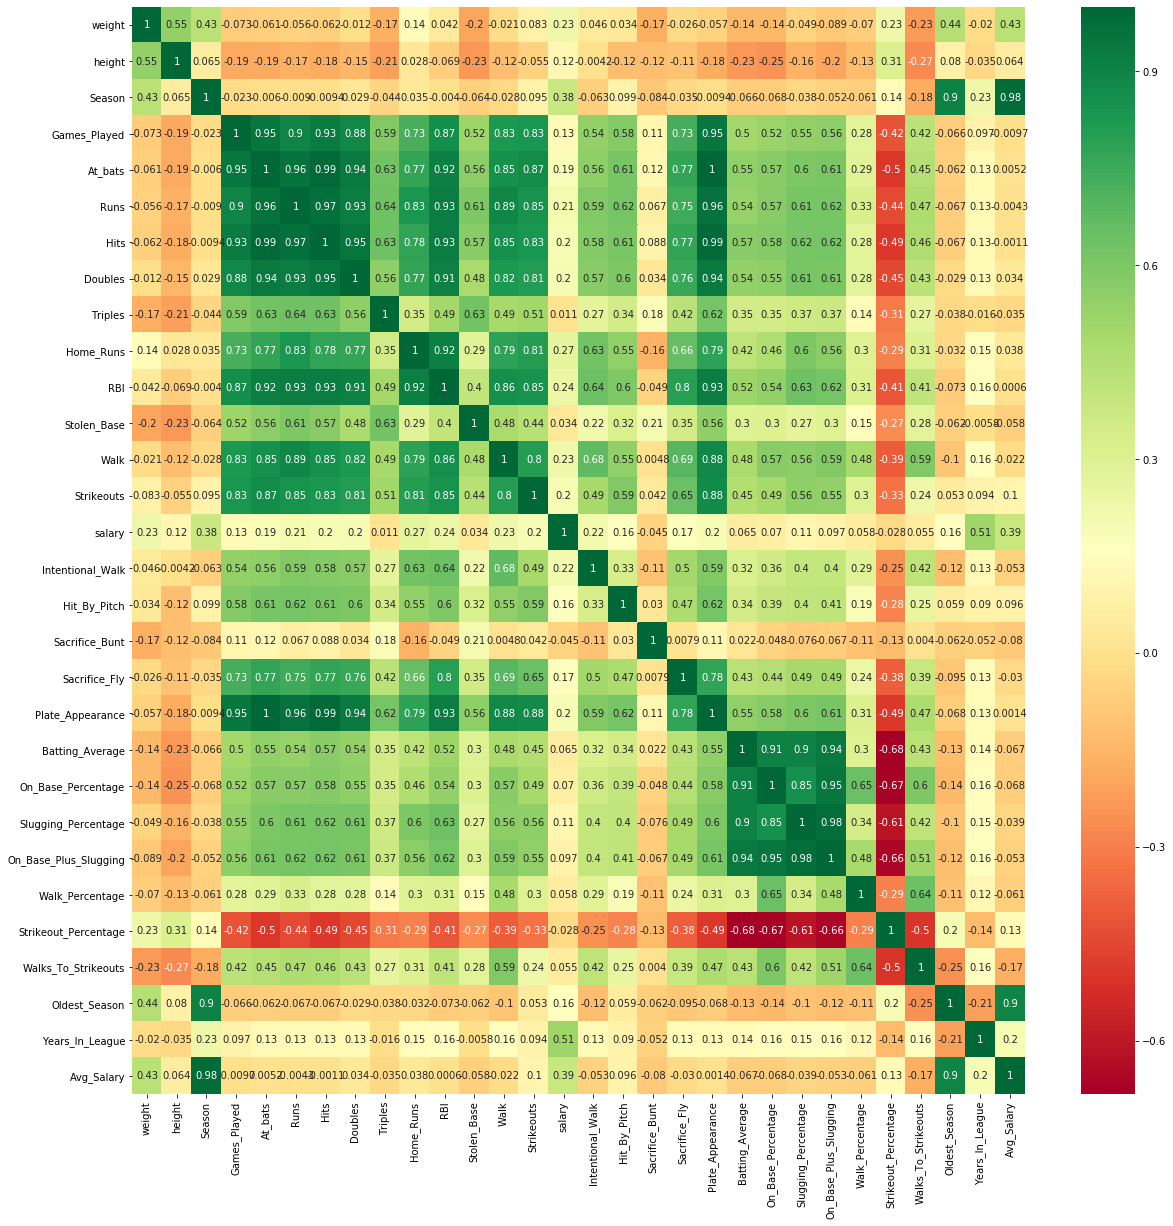

In [32]:
# get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [33]:
# mean absolute error
errors = df['Avg_Salary'] - df['salary']
mean_absolute_error = errors.abs().mean()
print(f"""If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of ${mean_absolute_error:,.0f}""")

If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of $2,246,635


In [34]:
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance',
       'Batting_Average', 'On_Base_Percentage', 'Slugging_Percentage',
       'On_Base_Plus_Slugging', 'Walk_Percentage', 'Strikeout_Percentage',
       'Walks_To_Strikeouts', 'Oldest_Season', 'Years_In_League',
       'Avg_Salary'],
      dtype='object')

In [35]:
# features
features = [
 'Season',
 'Games_Played',
 'At_bats',
 'Runs',
 'Hits',
 'Doubles',
 'Home_Runs',
 'RBI',
 'Walk',
 'Strikeouts',
 'Intentional_Walk',
 'Plate_Appearance',
 'On_Base_Percentage',
 'Batting_Average',
 'Slugging_Percentage',
 'On_Base_Plus_Slugging',
 'Walk_Percentage',
 'Strikeout_Percentage',
 'Walks_To_Strikeouts',
 'Years_In_League']

# shuffle data
df = shuffle(df)
# drop target
y = df.pop('salary')
X = df[features]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((12492, 20), (4164, 20), (4165, 20), (12492,), (4164,), (4165,))

In [36]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

               Specs         Score
11  Plate_Appearance  1.078906e+06
2            At_bats  9.249677e+05
4               Hits  2.989846e+05
7                RBI  1.977755e+05
3               Runs  1.818827e+05
9         Strikeouts  1.733050e+05
8               Walk  1.615703e+05
1       Games_Played  1.406012e+05
6          Home_Runs  7.831769e+04
5            Doubles  6.550210e+04


/Users/josephbell/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


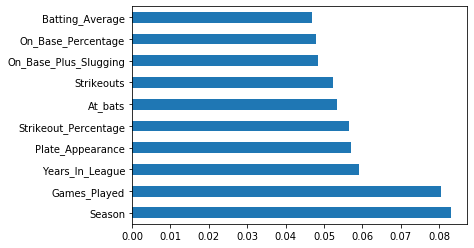

In [37]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();

In [38]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error 1792020.3539015607


In [39]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    KNeighborsRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error 1772676.9827130851


In [40]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RandomForestRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred))

/Users/josephbell/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error 1383548.6227651057


In [41]:
Season = 2016
Games_Played = 120
At_bats = 170
Runs = 25
Hits = 100
Doubles = 8
Home_Runs = 10
RBI = 70
Walk = 30
Strikeouts = 30
Intentional_Walk = 2
Plate_Appearance = 180
On_Base_Percentage = .400
Batting_Average = .300
Slugging_Percentage = .500
On_Base_Plus_Slugging = .900
Walk_Percentage = .10
Strikeout_Percentage = .30
Walks_To_Strikeouts = .20
Years_In_League = 10

X_test = [[
 Season,
 Games_Played,
 At_bats,
 Runs,
 Hits,
 Doubles,
 Home_Runs,
 RBI,
 Walk,
 Strikeouts,
 Intentional_Walk,
 Plate_Appearance,
 On_Base_Percentage,
 Batting_Average,
 Slugging_Percentage,
 On_Base_Plus_Slugging,
 Walk_Percentage,
 Strikeout_Percentage,
 Walks_To_Strikeouts,
 Years_In_League]]

y_pred = pipeline.predict(X_test)
print(f'Predicted salary of ${y_pred.astype(int)[0]:,.0f}')

Predicted salary of $13,430,587
